# Kwame's Zillow Zestimates Error Control

Table of contents with header links goes here.

## explore.ipynb

### When this section of the pipeline is done being coded, I will transfer internal code to ```explore.py``` and external code and output to the final notebook.

**I may make this the final notebook with a rename and cleanup.**

### Set up the environment

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import necessary packages/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt

from wrangle import get_zillow_data, prepare_zillow
from preprocessing import zillow_main_split, zillow_Xy_split, impute_nulls, zillow_scale
from explore import viz_logerror, corr_heatmap, ttest_viz, ttest_hypo
from model import create_cluster1, cluster1_viz, choose_k, intertia_k

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=13)

# default pandas decimal number display format
#pd.options.display.float_format = '{:20,.2f}'.format

### Acquire the data

In [2]:
df = get_zillow_data()
df.shape

(77580, 69)

### Tidy the data

In [3]:
df = prepare_zillow(df)
df.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt,decade,century
parcelid,,,,,,,,,,,
14297519,3.50,"3,100.00","33,634,931.00","-117,869,207.00",1,"1,998.00","1,023,282.00",0.03,7.50,199.00,19.00
17052889,1.00,"1,465.00","34,449,266.00","-119,281,531.00",2,"1,967.00","464,000.00",0.06,3.00,196.00,19.00
14186244,2.00,"1,243.00","33,886,168.00","-117,823,170.00",1,"1,962.00","564,778.00",0.01,5.00,196.00,19.00


### Summarize the clean data

In [4]:
df.shape

(52296, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52296 entries, 14297519 to 13083743
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathcnt     52296 non-null  float64
 1   sqft        52291 non-null  float64
 2   latitude    52296 non-null  float64
 3   longitude   52296 non-null  float64
 4   county      52296 non-null  int64  
 5   yearbuilt   52296 non-null  float64
 6   value       52295 non-null  float64
 7   logerror    52296 non-null  float64
 8   bathbedcnt  52296 non-null  float64
 9   decade      52296 non-null  float64
 10  century     52296 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 4.8 MB


In [6]:
df.isnull().sum()

bathcnt       0
sqft          5
latitude      0
longitude     0
county        0
yearbuilt     0
value         1
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

The remaining nulls have to be imputed after the data split so that we aren't cheating with our data sets.

### Split the data into train, validate, test.

In [7]:
# main split
train, validate, test = zillow_main_split(df)

In [8]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of validate data: {validate.shape}')
print(f'Shape of test data: {test.shape}')

Shape of train data: (29285, 11)
Shape of validate data: (12551, 11)
Shape of test data: (10460, 11)


### Impute the remaining nulls with medians.

In [9]:
train = impute_nulls(train)
train.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

In [10]:
validate = impute_nulls(validate)
validate.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

In [11]:
test = impute_nulls(test)
test.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

### Split the data into X and y train, X and y validate, X and y test.

In [12]:
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow_Xy_split(train, validate, test)

In [13]:
# checking to make sure data was split correctly
print(f'Shape of X train data: {X_train.shape}')
print(f'Shape of X validate data: {X_validate.shape}')
print(f'Shape of X test data: {X_test.shape}')
print('\n')
print(f'Shape of y train data: {y_train.shape}')
print(f'Shape of y validate data: {y_validate.shape}')
print(f'Shape of y test data: {y_test.shape}')

Shape of X train data: (29285, 10)
Shape of X validate data: (12551, 10)
Shape of X test data: (10460, 10)


Shape of y train data: (29285,)
Shape of y validate data: (12551,)
Shape of y test data: (10460,)


### Scale the data and encode county

In [14]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = zillow_scale(X_train, X_validate, X_test)
X_train_scaled.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century
parcelid,,,,,,,,,,
13060986,0.18,0.14,0.47,0.87,0.00,0.62,0.02,0.30,0.62,0.50
14323887,0.64,0.53,0.18,0.85,0.50,0.85,0.13,0.65,0.85,0.50
11921805,0.18,0.10,0.54,0.72,0.00,0.38,0.04,0.25,0.38,0.50


### Explore the data and create visualizations

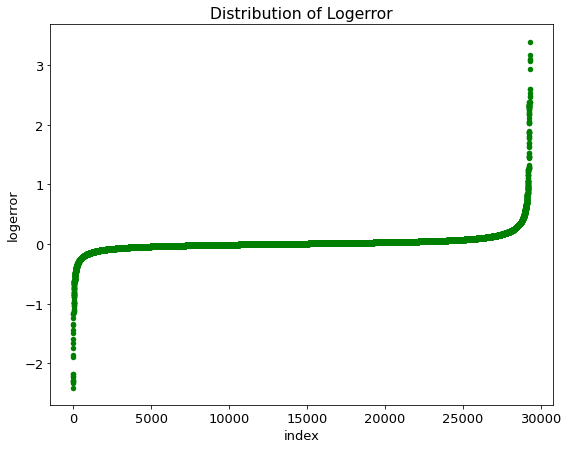

In [15]:
viz_logerror(train)

**There are outliers present, especially on the side of negative logerror. I will handle these on the next iteration of this section.**

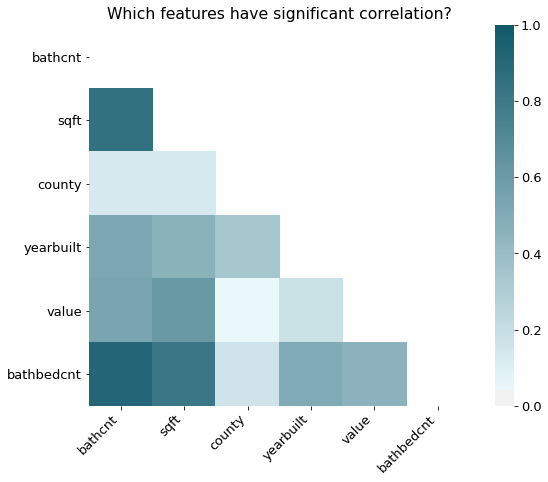

In [16]:
corr_heatmap(X_train_scaled)

(array([  32.,  210.,  454., 3149., 2975., 7336., 7995., 2579., 2055.,
        2500.]),
 array([188. , 189.3, 190.6, 191.9, 193.2, 194.5, 195.8, 197.1, 198.4,
        199.7, 201. ]),
 <a list of 10 Patch objects>)

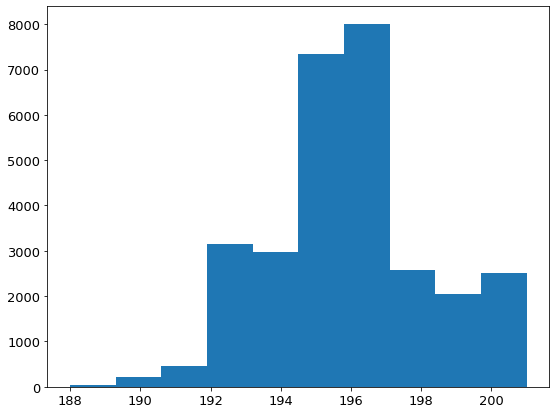

In [17]:
plt.hist(train.decade)

Text(0.5, 1.0, 'Which properties have more log error, by year built bins and county?')

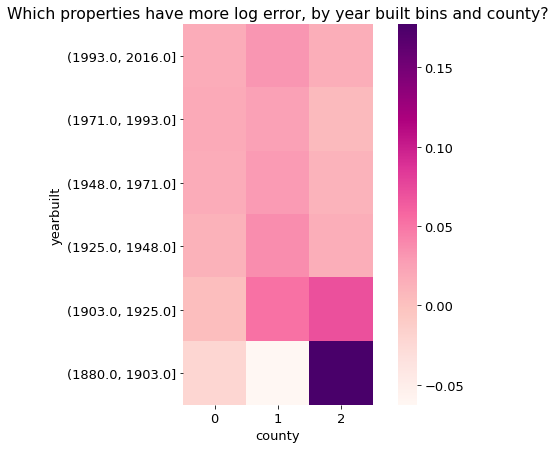

In [18]:
# pandas pivot
heatmap1_data = pd.pivot_table(train, values='logerror', 
                     index=pd.cut(train['yearbuilt'], bins=6, precision=0), 
                     columns='county')
heatmap1_data.sort_index(inplace=True, ascending=False)
sns.heatmap(heatmap1_data, cmap="RdPu", square=True)
plt.title('Which properties have more log error, by year built bins and county?')

'Los Angeles': 0,

'Orange': 1,

'Ventura': 2

Looks like properties built in the 1800s and early 1900s have slightly more log error, especially in Ventura county. Granted, there are not very many properties that meet those criteria, so let's do a statisical test to find out if it's significant or not. There seems to be slightly more log error in Orange county.

In [19]:
#keep this in final notebook
train.century.value_counts(dropna=False)

19.00    26753
20.00     2500
18.00       32
Name: century, dtype: int64

### One statistical test - 1 sample 2 tailed T-test: categorical vs cont.

## Is there a significant difference in the log error of Zestimates on properties built in the 1800s and the overall log error?

$
\begin{align*}
   H_0 & : \text{There is no difference in Zestimate log error in properties built in the 1800s and the overall log error.}
   \\
   H_a & : \text{There is a difference in Zestimate log error in properties built in the 1800s and the overall log error.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

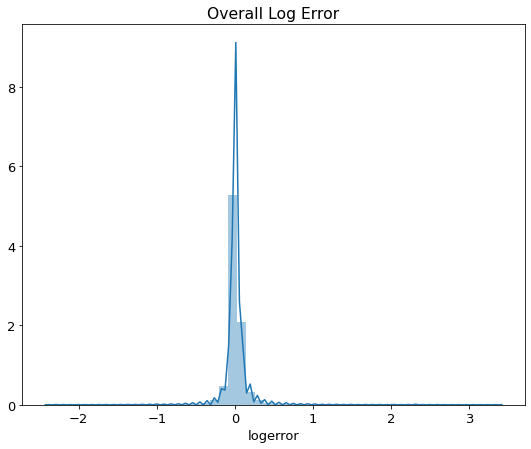

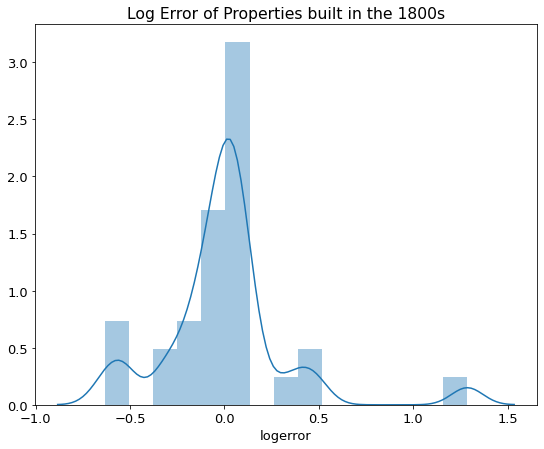

Compare the median and mean:
 0.01868501980613076 0.00695327101882


In [20]:
ttest_viz(train)

There are some outliers, but I will say that the mean and median are close enough for this iteration. I will remove outliers in the next iteration.

**Now that we know the variable has a normal distribution and we compared the mean and median, we can run the T-test.**

In [21]:
ttest_hypo(train)

t = -0.265
p = 0.793
We fail to reject the null hypothesis.


**There doesn't seem to be a statistically significant difference in log error in properties built in the 1800s and the overall log error.**

**However I do notice that the distribution of the log error of properties built in the 1800s is skewed differently from the overall log error.**

### Stats test 2?

In [22]:
train.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'logerror', 'bathbedcnt', 'decade', 'century'],
      dtype='object')

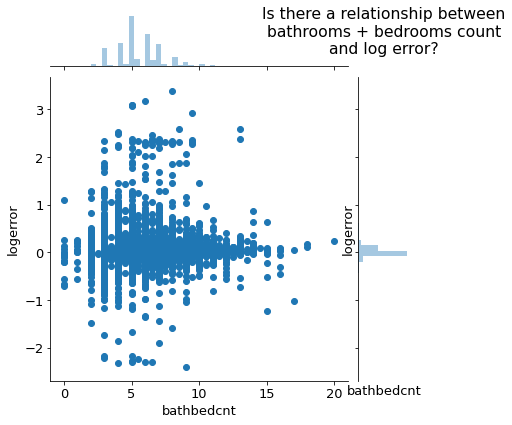

In [23]:
sns.jointplot(x="bathbedcnt", y="logerror", data=train)
plt.xlabel("bathbedcnt")
plt.ylabel("logerror")
plt.title("Is there a relationship between\nbathrooms + bedrooms count\nand log error?\n")
plt.show()

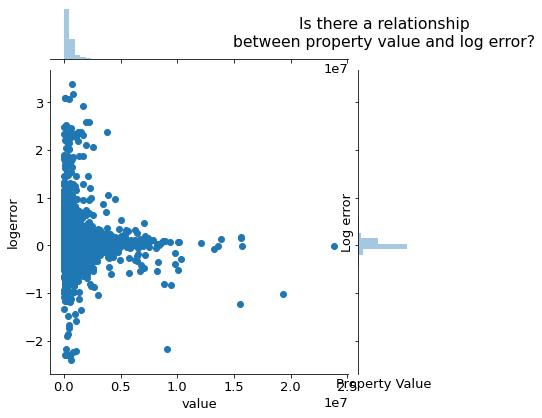

In [24]:
sns.jointplot(x="value", y="logerror", data=train)
plt.xlabel("Property Value")
plt.ylabel("Log error")
plt.title("Is there a relationship\nbetween property value and log error?\n")
plt.show()

It seems like there is definitely more error amongst lower value properties.

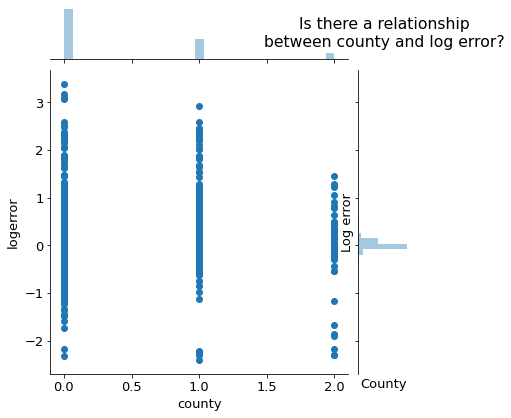

In [25]:
sns.jointplot(x="county", y="logerror", data=train)
plt.xlabel("County")
plt.ylabel("Log error")
plt.title("Is there a relationship\nbetween county and log error?\n")
plt.show()

More log error in Los Angeles county.

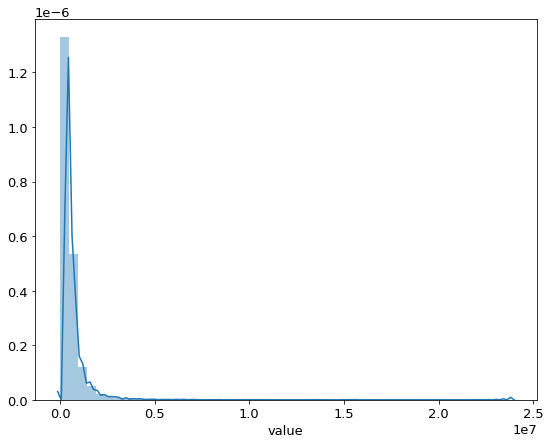

In [26]:
sns.distplot(train.value)

Looks normally distributed enough, so I can run a Pearson's R test on this. I will do that statistical testing in the next iteration through the pipeline.

### Next step in exploration: Study up on how to use clustering to make groups of like properties to target log error.

# Modeling

### Next step in modeling: Finish building a functioning MVP model, even if I don't totally understand how it works.

Note to self:

I kinda understood how to do it on the iris data but kind of lost how to use it here. Ask for help this week and join study sessions. Make sure to sleep enough too.

In [27]:
X_train_scaled.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'bathbedcnt', 'decade', 'century'],
      dtype='object')

In [28]:
X = X_train_scaled[['value', 'decade', 'bathbedcnt', 'sqft', 'longitude']]
kmeans, centroids = create_cluster1(X_train_scaled, X, 5)

In [29]:
X_train_scaled.groupby('cluster').mean()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century
cluster,,,,,,,,,,
0,0.19,0.10,0.38,0.80,0.25,0.60,0.01,0.27,0.59,0.50
1,0.21,0.11,0.52,0.54,0.02,0.56,0.02,0.28,0.55,0.50
2,0.14,0.08,0.46,0.65,0.02,0.37,0.02,0.21,0.35,0.50
3,0.28,0.17,0.44,0.81,0.27,0.84,0.03,0.34,0.84,0.66
4,0.26,0.15,0.62,0.33,0.65,0.76,0.03,0.33,0.76,0.61


In [30]:
X_train_scaled.groupby('cluster').median()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century
cluster,,,,,,,,,,
0,0.18,0.09,0.36,0.79,0.50,0.59,0.01,0.25,0.62,0.50
1,0.18,0.10,0.55,0.55,0.00,0.55,0.02,0.25,0.54,0.50
2,0.09,0.07,0.47,0.65,0.00,0.35,0.01,0.20,0.31,0.50
3,0.27,0.15,0.36,0.84,0.50,0.83,0.02,0.35,0.85,0.50
4,0.27,0.13,0.61,0.33,1.00,0.76,0.02,0.33,0.77,0.50


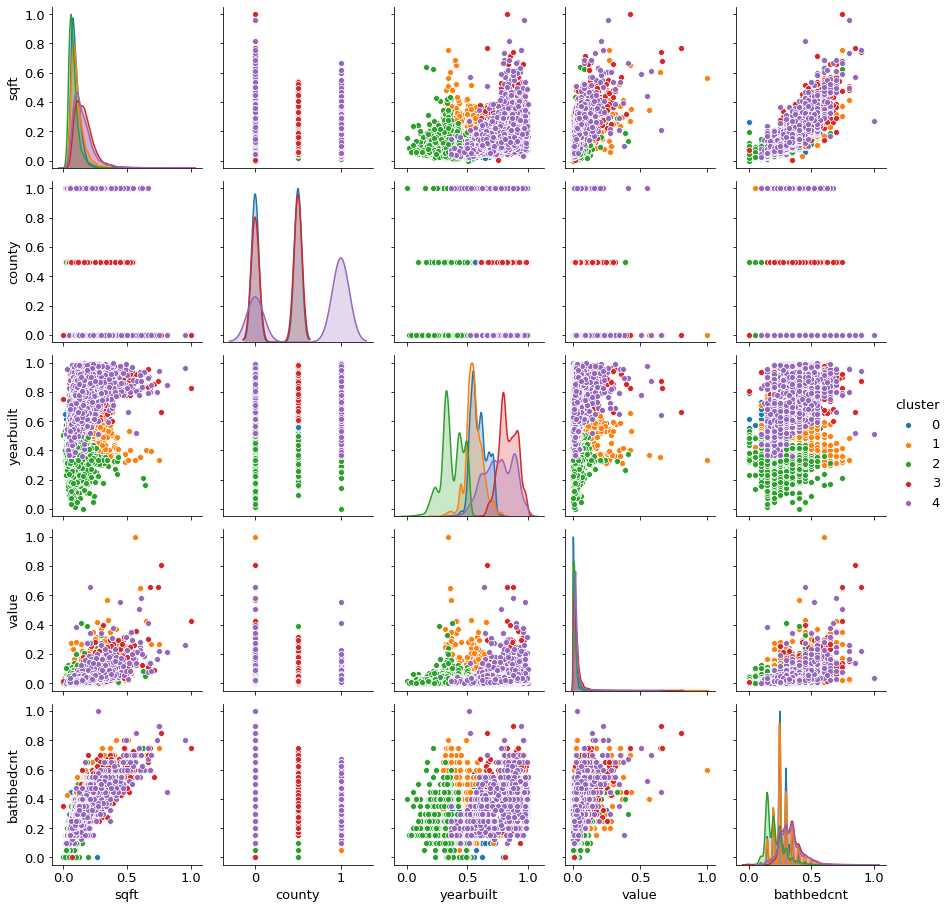

In [31]:
sns.pairplot(data=X_train_scaled.drop(columns=['latitude', 'longitude', 'century', 'decade', 'bathcnt']), hue='cluster')

In [37]:
train.latitude

parcelid
13060986          34,031,614.00
14323887          33,601,061.00
11921805          34,131,487.00
11504971          33,896,023.00
11603399          34,040,252.00
                   ...         
12118605          34,160,025.00
14124447          33,850,614.00
11906632          34,064,415.00
14201484          33,877,275.00
11099623          34,221,627.00
Name: latitude, Length: 29285, dtype: float64

In [50]:
housing.shape
housing

,parcelid,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,cluster
0.00,"13,060,986.00",0.18,0.14,0.47,0.87,0.00,0.62,0.02,0.30,0.62,0.50,0.00
1.00,"14,323,887.00",0.64,0.53,0.18,0.85,0.50,0.85,0.13,0.65,0.85,0.50,3.00
2.00,"11,921,805.00",0.18,0.10,0.54,0.72,0.00,0.38,0.04,0.25,0.38,0.50,2.00
3.00,"11,504,971.00",0.27,0.15,0.38,0.56,0.00,0.63,0.01,0.40,0.62,0.50,1.00
4.00,"11,603,399.00",0.27,0.18,0.47,0.56,0.00,0.52,0.08,0.35,0.54,0.50,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
0.55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.35,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.49,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.36,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [52]:
train.shape
train.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'logerror', 'bathbedcnt', 'decade', 'century'],
      dtype='object')

In [49]:
X_train_scaled.shape

(29285, 11)

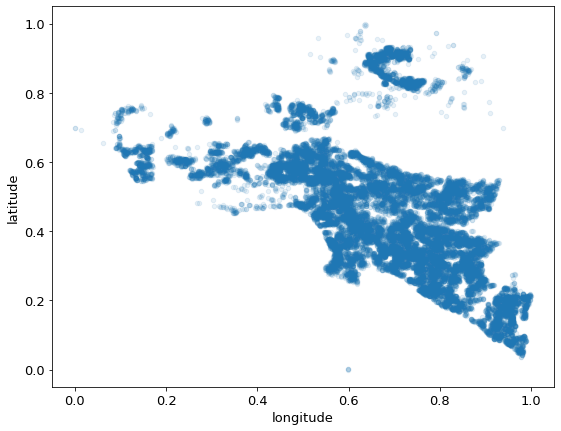

In [44]:
# plot log error by latitude and longitude
housing = X_train_scaled.copy()
housing = housing.reset_index()
to_append = pd.DataFrame(housing.longitude, housing.latitude)
housing = pd.concat([housing, to_append])

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In [56]:
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
housing.plot(kind="scatter", x="longitude", y="latitude",
    s=housing[y_train.logerror, label="clusters and log error",
    c="cluster", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
save_fig("housing_prices_scatterplot")
plt.show()

SyntaxError: invalid syntax (<ipython-input-56-f0956a1cce3f>, line 4)

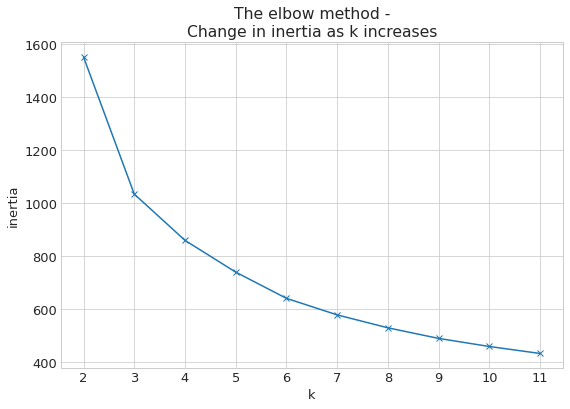

In [33]:
intertia_k(X)

**Judging by the elbow method, the sweet spot for my k-value should be around 4 or 5.**

In [ ]:
# 'value', 'decade', 'bathbedcnt', 'sqft', 'longitude'

# 'value', 'decade', 'sqft', 'longitude'

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.sepal_length, X.petal_length, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='sepal length', ylabel='petal length')

# Conclusion and Takeaways - How to prevent future error in Zestimates